<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_roc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

 70% 41.0M/58.3M [00:01<00:00, 34.0MB/s]
100% 58.3M/58.3M [00:01<00:00, 54.8MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 220MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 220MB/s]
 63% 33.0M/52.2M [00:00<00:00, 42.4MB/s]
100% 52.2M/52.2M [00:00<00:00, 82.2MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]


In [ ]:
n_fold=5
lr=0.0001

In [ ]:
import pandas as pd
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv')
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv')

In [ ]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols=list(trn.select_dtypes(include=object))
for col in cols:
  le=LabelEncoderExt()
  le.fit(trn[col].astype(str))
  trn[col]=le.transform(trn[col].astype(str))
  tst[col] = tst[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  tst[col]=le.transform(tst[col].astype(str))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
ss=StandardScaler()
frd=trn['isFraud']
ls=list(trn)
trn=ss.fit_transform(trn.drop(['isFraud'],1))
trn=pd.DataFrame(trn)

In [ ]:
ls.remove('isFraud')
trn.columns=ls
trn['isFraud']=frd

ls=list(tst)
tst=ss.fit_transform(tst)
tst=pd.DataFrame(tst)
tst.columns=ls

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 1671.53 MB
Memory usage after optimization is: 417.88 MB
Decreased by 75.0%
Memory usage of dataframe is 1430.33 MB
Memory usage after optimization is: 357.58 MB
Decreased by 75.0%


In [ ]:
trn_n=pd.read_csv('train_transaction.csv.zip')
tst_n=pd.read_csv('test_transaction.csv.zip')
trn['month']=trn_n['TransactionDT']//(86400*30)
trn_n.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

trn_ls=list(trn_n)
tst_ls=list(tst_n)
for col in trn:
  if col in trn_ls:
    trn[col+'_isna']=trn_n[col].isna().astype('uint8')
for col in tst:
  if col in tst_ls:
    tst[col+'_isna']=tst_n[col].isna().astype('uint8')
import gc
del([trn_n,tst_n])
gc.collect()

0

In [ ]:
y_pred=[0.1,0.6,0.8,0.7,0.9]
y_true=[1,0,1,1,0]
pos=tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
pos=tf.expand_dims(pos, 0)

In [ ]:
neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
neg=tf.expand_dims(neg, 1)

In [ ]:
pos,neg

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.1, 0.8, 0.7]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.6],
        [0.9]], dtype=float32)>)

In [ ]:
tf.zeros_like(pos * neg)+pos

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.1, 0.8, 0.7],
       [0.1, 0.8, 0.7]], dtype=float32)>

In [ ]:
difference

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.5       ,  0.19999999,  0.09999996],
       [-0.79999995, -0.09999996, -0.19999999]], dtype=float32)>

In [ ]:
difference=tf.zeros_like(pos * neg) + pos - neg
tf.boolean_mask(difference, difference < 0.0)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.5       , -0.79999995, -0.09999996, -0.19999999], dtype=float32)>

In [ ]:

def rac(y_true, y_pred):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):
        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)
        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.6
        p     = 0.5
        difference = tf.zeros_like(pos * neg) + pos - neg - gamma
        masked = tf.boolean_mask(difference, difference < 0.0)
        return tf.reduce_sum(tf.pow(-masked, p))

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        if self.ep%10==0:
          y_pred_val = self.model.predict(self.x_val)
          roc_val = roc_auc_score(self.y_val, y_pred_val)
          print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def load_model():
  K.clear_session()
  inp=Input((593,))
  x=Dense(256,activation='relu')(inp)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=inp,outputs=x)
  return mod
for en,month in enumerate(range(1,5)):
  train=trn.loc[trn['month']>=month]
  test=trn.loc[trn['month']<month]
  train=train.drop(['month'],1)
  test=test.drop(['month'],1)
  mod=load_model()
  roc = RocCallback(
                  validation_data=(test.drop(['isFraud'],1), test['isFraud']))
  mod.compile(optimizer=Adam(0.00001,decay=1e-5),loss=rac,metrics='accuracy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=1000,callbacks=[es,roc])
  del([train,test])
  gc.collect()
  if en==0:
    pre=mod.predict(tst)/n_fold
  else:
    pre+=mod.predict(tst)/n_fold

Epoch 1/1000
225/225 [==============================] - 2s 8ms/step - loss: 88494.5625 - accuracy: 0.5906 - val_loss: 58954.6562 - val_accuracy: 0.5173
Epoch 2/1000
225/225 [==============================] - 1s 6ms/step - loss: 70781.7891 - accuracy: 0.6502 - val_loss: 55246.7891 - val_accuracy: 0.5191
Epoch 3/1000
225/225 [==============================] - 1s 6ms/step - loss: 64886.5898 - accuracy: 0.6760 - val_loss: 54143.5938 - val_accuracy: 0.5187
Epoch 4/1000
225/225 [==============================] - 1s 6ms/step - loss: 61984.7031 - accuracy: 0.6870 - val_loss: 53229.5508 - val_accuracy: 0.5178
Epoch 5/1000
225/225 [==============================] - 1s 6ms/step - loss: 60035.5859 - accuracy: 0.6931 - val_loss: 52538.1016 - val_accuracy: 0.5160
Epoch 6/1000
225/225 [==============================] - 1s 6ms/step - loss: 58830.0234 - accuracy: 0.6974 - val_loss: 52011.9180 - val_accuracy: 0.5147
Epoch 7/1000
225/225 [==============================] - 1s 6ms/step - loss: 57746.8086 -

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


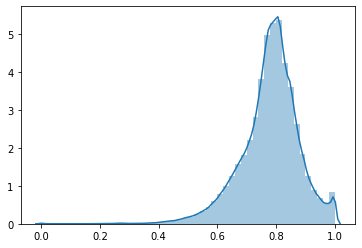

In [ ]:
pre=mod.predict(tst)
import seaborn as sns
sns.distplot(pre)

In [ ]:

for en,month in enumerate(range(2,5)):
  train=trn.loc[trn['month']>=month]
  test=trn.loc[trn['month']<month-1]
  train=train.drop(['month'],1)
  test=test.drop(['month'],1)
  mod=load_model()
  mod.compile(optimizer=Adam(0.00001,decay=1e-5),loss='binary_crossentropy',metrics='accuracy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=1000,callbacks=[es])
  del([train,test])
  gc.collect()
  if en==0:
    pre_2=mod.predict(tst)/4
  else:
    pre_2+=mod.predict(tst)/4

Epoch 1/1000
181/181 [==============================] - 2s 9ms/step - loss: 0.8374 - accuracy: 0.5165 - val_loss: 0.8940 - val_accuracy: 0.2299
Epoch 2/1000
181/181 [==============================] - 1s 5ms/step - loss: 0.7921 - accuracy: 0.5403 - val_loss: 0.8461 - val_accuracy: 0.3489
Epoch 3/1000
181/181 [==============================] - 1s 6ms/step - loss: 0.7583 - accuracy: 0.5599 - val_loss: 0.8078 - val_accuracy: 0.4079
Epoch 4/1000
181/181 [==============================] - 1s 6ms/step - loss: 0.7320 - accuracy: 0.5798 - val_loss: 0.7800 - val_accuracy: 0.4520
Epoch 5/1000
181/181 [==============================] - 1s 6ms/step - loss: 0.7100 - accuracy: 0.6005 - val_loss: 0.7576 - val_accuracy: 0.4933
Epoch 6/1000
181/181 [==============================] - 1s 6ms/step - loss: 0.6882 - accuracy: 0.6207 - val_loss: 0.7345 - val_accuracy: 0.5424
Epoch 7/1000
181/181 [==============================] - 1s 5ms/step - loss: 0.6696 - accuracy: 0.6409 - val_loss: 0.7150 - val_accuracy:

In [ ]:

for en,month in enumerate(range(3,5)):
  train=trn.loc[trn['month']>=month]
  test=trn.loc[trn['month']<month-2]
  train=train.drop(['month'],1)
  test=test.drop(['month'],1)
  mod=load_model()
  mod.compile(optimizer=Adam(0.00001,decay=1e-5),loss='binary_crossentropy',metrics='accuracy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=1000,callbacks=[es])
  del([train,test])
  gc.collect()
  if en==0:
    pre_3=mod.predict(tst)/3
  else:
    pre_3+=mod.predict(tst)/3

Epoch 1/1000
136/136 [==============================] - 1s 10ms/step - loss: 0.8432 - accuracy: 0.5168 - val_loss: 0.7915 - val_accuracy: 0.3544
Epoch 2/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.8034 - accuracy: 0.5359 - val_loss: 0.7493 - val_accuracy: 0.4854
Epoch 3/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.7740 - accuracy: 0.5515 - val_loss: 0.7247 - val_accuracy: 0.5517
Epoch 4/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.7509 - accuracy: 0.5666 - val_loss: 0.7093 - val_accuracy: 0.5889
Epoch 5/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.7316 - accuracy: 0.5824 - val_loss: 0.6940 - val_accuracy: 0.6303
Epoch 6/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.7128 - accuracy: 0.5986 - val_loss: 0.6822 - val_accuracy: 0.6649
Epoch 7/1000
136/136 [==============================] - 1s 6ms/step - loss: 0.6972 - accuracy: 0.6131 - val_loss: 0.6701 - val_accuracy

In [ ]:
pre=(pre_2+pre_3+pre)/3
pre.shape

(506691, 1)

In [ ]:

ss=pd.read_csv('sample_submission.csv.zip')
ss['isFraud']=pre
ss=ss.set_index('TransactionID')
ss.to_csv('sub.csv')

In [ ]:
ss.head()

,isFraud
TransactionID,
3663549,0.024190
3663550,0.027627
3663551,0.030551
3663552,0.021533
3663553,0.025596


In [ ]:
ss.to_csv('sub.csv')